# Model Evaluation

Evaluating the performance of classification models is a crucial component of the modeling process. The effective evaluation of a classification model entails producing accurate, robust measurements of model performance that are repeatable and useful. These measures should also reflect and explicitly measure the uncertainty inherent to the evaluation process.

Here, we'll use the `scikit-learn` (`sklearn`) package to explore the use of several classification algorithms and corresponding measures of evaluation. Let's begin by fetching the Iris dataset from the UCI Machine Learning repository.

In [1]:
import numpy as np
import pandas as pd

# Read in the file URL.
file_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
data = pd.read_csv(file_url, names=['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width', 'Name'], header=None)

X = data.iloc[:, :-1]  # features
y = data.iloc[:, -1]  # class

print(X.head())
print()
print(y.head())

   Sepal Length  Sepal Width  Petal Length  Petal Width
0           5.1          3.5           1.4          0.2
1           4.9          3.0           1.4          0.2
2           4.7          3.2           1.3          0.2
3           4.6          3.1           1.5          0.2
4           5.0          3.6           1.4          0.2

0    Iris-setosa
1    Iris-setosa
2    Iris-setosa
3    Iris-setosa
4    Iris-setosa
Name: Name, dtype: object


## Training and Testing Sets

The first thing we should do is separate the available data into training and testing sets. We should always fit the model on the training data and then evaluate it on separate testing data. `sklearn` provides a convenient function to do this. Let's save 20% of our data for testing, and use the rest for fitting our model.

In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Now we'll create a simple classification model. Here, we use the _k_-nearest neighbor classifier, with the default parameters provided by the implementation in `sklearn`. We'll fit this model on the training data, which includes corresponding sets of training features (`X`) and class values (`y`).

In [3]:
from sklearn.neighbors import KNeighborsClassifier

clf_knn = KNeighborsClassifier()
clf_knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

Now, let's incorporate our preprocessing steps. To avoid "snooping" on our testing data, we should perform the preprocessing independently for the training and testing datasets.

One point to note here is that as a consequence of this independence, the training and testing data may become incongruous. For example, if we are creating indicator variables for categorical data, a particular categorical value that appears in our testing data but not our training data will have an associated column in the testing data but not in the training data. As a consequence, the number of features we generate for the training and testing sets may differ; we thus have to address this potential difference. A simple way to address this issue is to ignore any columns in the testing data that do not appear in the training data.

In [4]:
from sklearn.preprocessing import Imputer

# Impute numeric features/columns.
def impute_numeric(X):
    # Initialize an Imputer with the appropriate imputation strategy.
    imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
    for col in X.select_dtypes(include=['float64']).columns:
        # Transform/impute the feature using the mean.
        X[col] = X[col].fillna(X[col].mean())
    return X

# Impute nominal features/columns.
def impute_nominal(X):
    for col in X.select_dtypes(include=['object']).columns:
        # Transform/impute the feature using the mode.
        X[col] = X[col].fillna(pd.Series(X[col].value_counts().index[0]))
    return X

# Encode nominal features/columns with indicator/dummy variables.
def dummify(X):
    dummy_cols = [X.columns[i] for i, tp in enumerate(X.dtypes) if tp == 'object']
    for col in dummy_cols:
        temp = pd.get_dummies(X[col], prefix=col)
        X = pd.concat([X, temp], axis=1).drop(col, axis=1)
    return X

# Encode and transform class values to numeric type.
def encode(y): 
    le = LabelEncoder()
    le.fit(y)
    y = le.transform(y).astype(int)
    y = pd.Series(y, name=data.columns[-1])
    return y

# Preprocess the training and testing sets separately.
def preprocess(train, test):
    # Prepare training data.
    X_train = train.iloc[:,:-1]
    y_train = train.iloc[:,-1]

    X_train = impute_numeric(X_train)
    X_train = impute_nominal(X_train)
    X_train = dummify(X_train)
    #y_train = encode(y_train)

    # Prepare testing data.
    X_test = test.iloc[:,:-1]
    y_test = test.iloc[:,-1]

    X_test = impute_numeric(X_test)
    X_test = impute_nominal(X_test)
    X_test = dummify(X_test)
    #y_test = encode(y_test)

    # Get the columns in training data but not in testing data.
    col_to_add = np.setdiff1d(X_train.columns, X_test.columns)
    # Add these columns to testing data, setting them equal to zero.
    for c in col_to_add:
        X_test[c] = 0
    # Select and reorder the test columns using the train columns.
    X_test = X_test[X_train.columns]

    return X_train, y_train, X_test, y_test

## Accuracy

Now let's evaluate our classification model. Perhaps the simplest method of evaluation is the measure of accuracy. Accuracy is simply defined as the number of correct predictions over the total number of predictions.

If we consider each prediction correct if it is identical to the corresponding instance's class value, then accuracy is simply the average number of correct predictions across our testing dataset. Using `NumPy`, we can implement a simple function to compute the average given two lists, one for the actual values and one for the predicted values.

In [5]:
def accuracy_score(y_true, y_pred):
    """Accuracy classification score.

    Parameters
    ----------
    y_true : array, shape = [n_instances]
        Actual target values.
    y_pred : array, shape = [n_instances]
        Predicted target values.

    Returns
    -------
    score : float
        Returns the fraction of correctly classified instances.
    """
    score = y_true == y_pred
    return np.average(score)

Now we can use our fitted model to generate predictions for the testing data, and score the predictions according to their accuracy.

In [6]:
y_pred = clf_knn.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("{:.3f}".format(acc))

0.967


Note that `sklearn` also has a built-in accuracy scoring function.

In [7]:
from sklearn.metrics import accuracy_score

y_pred = clf_knn.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("{:.3f}".format(acc))

0.967


## Confusion Matrix

We can use a confusion matrix to better understand how instances are being classified. A confusion matrix breaks down the model predictions on a dataset for which the actual labels are known. It produces a matrix that encodes all combinations of the actual and predicted labels.

We can use `pandas` to implement a simple confusion matrix using the `crosstab` function that again uses the actual values and predicted values as inputs.

In [8]:
def confusion_matrix(y_true, y_pred):
    """Confusion matrix.

    Parameters
    ----------
    y_true : array, shape = [n_instances]
        Actual target values.
    y_pred : array, shape = [n_instances]
        Predicted target values.

    Returns
    -------
    cm : DataFrame
        Returns the confusion matrix.
    """
    return pd.crosstab(y_true, y_pred,
                       rownames=['Actual'], colnames=['Predicted'])

In [9]:
confusion_matrix(y_test, y_pred)

Predicted,Iris-setosa,Iris-versicolor,Iris-virginica
Actual,,,
Iris-setosa,10,0,0
Iris-versicolor,0,10,1
Iris-virginica,0,0,9


Note that `sklearn` also has a built-in confusion matrix function.

In [10]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[10,  0,  0],
       [ 0, 10,  1],
       [ 0,  0,  9]])

## Imbalanced Data

In some cases, we find that a measure like accuracy may be misleading. In particular, for datasets with a skewed distribution of class values, a model with high accuracy may prove less useful than a model with lower accuracy. To see why, let's look at a different dataset.

The Adults dataset is composed of information extracted from the U.S. Census Bureau database. The data includes a variety of personal information on over 32,000 individuals, with the task of predicting whether a given person makes over $50k per year.

In [11]:
file_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
data2 = pd.read_csv(file_url, header=None)

X = data2.iloc[:, :-1]  # features
y = data2.iloc[:, -1]  # class

print(X.head())
print()
print(y.head())

   0                  1       2           3   4                    5   \
0  39          State-gov   77516   Bachelors  13        Never-married   
1  50   Self-emp-not-inc   83311   Bachelors  13   Married-civ-spouse   
2  38            Private  215646     HS-grad   9             Divorced   
3  53            Private  234721        11th   7   Married-civ-spouse   
4  28            Private  338409   Bachelors  13   Married-civ-spouse   

                   6               7       8        9     10  11  12  \
0        Adm-clerical   Not-in-family   White     Male  2174   0  40   
1     Exec-managerial         Husband   White     Male     0   0  13   
2   Handlers-cleaners   Not-in-family   White     Male     0   0  40   
3   Handlers-cleaners         Husband   Black     Male     0   0  40   
4      Prof-specialty            Wife   Black   Female     0   0  40   

               13  
0   United-States  
1   United-States  
2   United-States  
3   United-States  
4            Cuba  

0     <

We can observe that only about 24% of the individuals recorded in the dataset make over $50k per year. This is known as an imbalanced classification problem, where the class values are not equally represented in the data.

In [12]:
y.value_counts()

 <=50K    24720
 >50K      7841
Name: 14, dtype: int64

Before we do any modeling, we have to preprocess the data. Here we transform categorical features into dummy variables and convert the classes into binary `0` and `1` outcomes. Class `0` will correspond to `<=50K`, while Class `1` will correspond to `>50K`.

In [13]:
from sklearn.preprocessing import LabelEncoder

X = pd.get_dummies(X)
le = LabelEncoder()
y = le.fit_transform(y)

Now, let's not even train a model. Instead, let's simply predict every testing instance as a Class `0` (<=50K) value.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

y_pred = np.zeros(y_test.shape)
acc = accuracy_score(y_test, y_pred)
print(acc)

0.755258713343


We find that, because roughly 76% of the instances belong to Class `0`, we obtain 76% without a model. In some datasets, over 99% of the data could belong to a particular class, giving us over 99% accuracy! Often, however, we're interested in attempting to model the rarer outcome, even if it decreases the overall accuracy of our model.

## ROC Curves

The receiver operating characteristic (ROC) curve is way to capture the tradeoff between true positive predictions and false positive predictions. To compute the curve for a binary classification problem, we need to calculate the probabilities for the rare (Class `1`) instances and the corresponding correct labels.

In [15]:
clf_knn2 = KNeighborsClassifier()
clf_knn2.fit(X_train, y_train)
y_prob = clf_knn2.predict_proba(X_test)[:,1]

With this information, we can now generate the sequence of false positive rates and true positive rates that form the ROC curve. We can also calculate the area under the ROC curve (AUROC), a single measure of classification performance that is between 0.5 (random) and 1.0 (perfect).

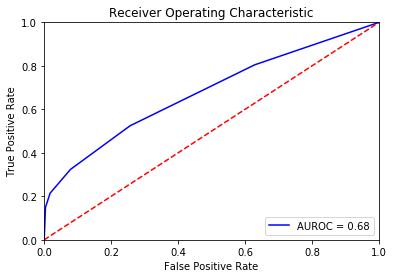

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve
                          
# Calculate the fpr and tpr for all thresholds of the classification.
fpr, tpr, threshold = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve.
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUROC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Cross Validation

To get a more robust estimate of classification performance, no matter what performance measure we apply, we can use cross-validation. In cross-validation, we'll use each instance as both a training and testing instance. We do this by separating the data into _k_ non-overlapping sets or folds, and training on _k-1_ folds will use the remaining fold as our testing set. We use each fold once as a testing set, resulting in _k_ iterations or repetitions of the learning process. In stratified cross-validation, we ensure that the proportion of class values assigned to each fold are approximately equal across folds.

Here we use the `sklearn` function `StratifiedKFold` to perform a 10-fold stratified cross-validation procedure. Each fold, we preprocess the training and testing datasets, fit a model, generate predictions, and measure their accuracy. We can append these accuracy scores to a list, producing 10 accuracy scores, one for each repetition of the procedure. We can then average these accuracy scores to get the average accuracy of the algorithm across the 10 folds.

In [17]:
from sklearn.model_selection import StratifiedKFold

# Transform/encode the class values from nominal to numeric.
data.iloc[:, -1] = encode(data.iloc[:, -1])

# Split the data into 10 stratified folds.
skf = StratifiedKFold(n_splits=10, shuffle=True)
skf_acc = []

# Iterate over the folds.
for train_index, test_index in skf.split(data.iloc[:,:-1], data.iloc[:,-1]):
    train, test = data.iloc[train_index], data.iloc[test_index]

    # Preprocess the training and testing sets.
    X_train, y_train, X_test, y_test = preprocess(train, test)

    # Fit the model on training set X and y.
    clf_knn2.fit(X_train, y_train)

    # Predict y for testing set X.
    y_pred = clf_knn2.predict(X_test)

    # Evaluate accuracy.
    skf_acc.append(accuracy_score(y_test, y_pred))

print(pd.DataFrame(skf_acc, columns=['KNN']).describe())

             KNN
count  10.000000
mean    0.973333
std     0.034427
min     0.933333
25%     0.933333
50%     1.000000
75%     1.000000
max     1.000000


## Housing Dataset

Let's practice applying what we've learned to a house price dataset for Ames, Iowa.

In [18]:
df_houses = pd.read_excel('http://www.amstat.org/publications/jse/v19n3/decock/AmesHousing.xls')
print(df_houses.head())

   Order        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0      1  526301100           20        RL         141.0     31770   Pave   
1      2  526350040           20        RH          80.0     11622   Pave   
2      3  526351010           20        RL          81.0     14267   Pave   
3      4  526353030           20        RL          93.0     11160   Pave   
4      5  527105010           60        RL          74.0     13830   Pave   

  Alley Lot Shape Land Contour    ...     Pool Area Pool QC  Fence  \
0   NaN       IR1          Lvl    ...             0     NaN    NaN   
1   NaN       Reg          Lvl    ...             0     NaN  MnPrv   
2   NaN       IR1          Lvl    ...             0     NaN    NaN   
3   NaN       Reg          Lvl    ...             0     NaN    NaN   
4   NaN       IR1          Lvl    ...             0     NaN  MnPrv   

  Misc Feature Misc Val Mo Sold Yr Sold Sale Type  Sale Condition  SalePrice  
0          NaN        0       5    20

### 1. Perform all of the steps necessary to prepare the data for classification.  For this dataset, these steps include dropping or filling missing values, separating the features and class, transforming categorical features to dummy variables, and binning SalePrice into two class outcomes, 'high' or 'low'.

In [19]:
# Code goes here.

### 2. Fit an artificial neural network (ANN) to the data, with 80% using for training and 20% used for testing.

In [20]:
# Code goes here.

### 3. Print the accuracy of the fit ANN on the testing data.

In [21]:
# Code goes here.

### 4. Show the ROC curve for the fit ANN on the testing data and print the area under the ROC curve (AUROC) value.

In [22]:
# Code goes here.

### 5. Again fit an artificial neural network (ANN) to the data, but this time using 10-fold cross-validation.

In [23]:
# Code goes here.

### 6. Print the average accuracy of the fit ANN across the 10 (testing) folds.

In [24]:
# Code goes here.

### 7. Print the average AUROC value of the fit ANN across the 10 (testing) folds.

In [25]:
# Code goes here.